In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import cv2
from numpy.fft import fft2, ifft2

In [2]:
# from math import pi, exp

# def gaussian_pdf_2D(x, y, sigma=1):
#     exp_term = -(x*x + y*y) / (2.*sigma*sigma)
#     const_term = 1/(2*pi*(sigma**2))
#     return const_term * exp(exp_term)

# def get_gaussian_filter(kernel_size=(3,3), sigma=1):
#     if type(kernel_size) == type(1):
#         m = n = kernel_size
#     else:
#         m, n = kernel_size
#     if (m%2 != 1) or (n%2 != 1):
#         raise Exception("Kernel size must be odd ", kernel_size)
#     gaussian_kernel = np.zeros((m,n))
#     center_x = (n+1) // 2 -1
#     center_y = (m+1) // 2 -1
#     for u in range(n):
#         for v in range(m):
#             gaussian_kernel[v, u] = gaussian_pdf_2D(u-center_x, v-center_y, sigma)
#     gaussian_kernel /= gaussian_kernel.sum()
#     return gaussian_kernel

In [3]:
# def zero_padding(img, size=(1,1)):
#     m, n = img.shape
#     img_pad = np.zeros((m+2*oy, n+2*ox))
#     img_pad[oy:-oy, ox:-ox] = img
#     return img_pad

# def flip_kernel(kernel):
#     return kernel[::-1, ::-1]
    
# def convolution_2D(img, kernel, padding=True):
#     kernel = flip_kernel(kernel)
#     p, q = kernel.shape
#     ox = (q-1)//2
#     oy = (p-1)//2
#     if padding:
#         img = zero_padding(img, size=(oy,ox))
#         m, n = img.shape
#     output_img = np.zeros((m, n))
#     for cy in range(oy, m-oy):
#         for cx in range(ox, n-ox):
#             img_window = img[(cy-oy):(cy+oy)+1:, (cx-ox):(cx+ox)+1]
#             output_img[cy, cx] = np.sum(img_window*kernel)
#     output_img = output_img[oy:-oy, ox:-ox]
#     return output_img

In [4]:
# def zero_padding(img, size=(1,1)):
#     if type(size) == type(1):
#         oy = ox = size
#     else:
#         oy, ox = size
#     m, n = img.shape
#     img_pad = np.zeros((m+2*oy, n+2*ox))
#     img_pad[oy:-oy, ox:-ox] = img
#     return img_pad

# def flip_kernel(kernel):
#     return kernel[::-1, ::-1]
    
# def convolution_2D(img, kernel, padding=True):
#     if len(img.shape) != 2:
#         raise Exception("Only support gray image right now !", img.shape)
#     kernel = flip_kernel(kernel)
#     m, n = img.shape
#     p, q = kernel.shape
    
#     ox = (q-1)//2
#     oy = (p-1)//2
#     if padding:
#         img = zero_padding(img, size=(oy,ox))
#         m, n = img.shape
    
#     output_img = np.zeros((m, n))
#     for cy in range(oy, m-oy):
#         for cx in range(ox, n-ox):
#             img_window = img[(cy-oy):(cy+oy)+1:, (cx-ox):(cx+ox)+1]
#             output_img[cy, cx] = np.sum(img_window*kernel)
            
#     output_img = output_img[oy:-oy, ox:-ox]
#     return output_img

In [5]:
# def subsampling(img, size=(64,64)):
#     if len(img.shape) != 2:
#         raise Exception("Only support gray image right now !", img.shape)
#     m, n = img.shape
#     sy = m/size[0]
#     sx = n/size[1]
#     img_sub = np.zeros(size)
#     for row in range(size[0]):
#         for col in range(size[1]):
#             r = min(row*sy, m-1)
#             c = min(col*sx, n-1)
#             img_sub[row][col] = img[int(r)][int(c)]
#     return img_sub

# def nearest_interpolation(img, size=(128,128)):
#     m, n = img.shape
#     img_up = np.zeros(size)
#     sy = size[0]/m
#     sx = size[1]/n
#     for y in range(m):
#         for x in range(n):
#             y_low = int(y*sy)
#             y_high = int((y+1)*sy)
#             x_low = int(x*sx)
#             x_high = int((x+1)*sx)
#             img_up[y_low:y_high, x_low:x_high] = img[y,x] 
#     return img_up

In [104]:
def get_gaussian_filter():
    gaussian_kernel = np.array(
        [[1, 4, 6, 4,1],
         [4,16,24,16,4],
         [6,24,36,24,6],
         [4,16,24,16,4],
         [1, 4, 6, 4,1]
            ]) / 256
    return gaussian_kernel

def zero_padding(img, size=(1,1)):
    if type(size) == type(1):
        oy = ox = size
    else:
        oy, ox = size
    shape = img.shape
    shape = shape[0] + 2*oy, shape[1] + 2*oy, shape[2]
    img_pad = np.zeros(shape)
    img_pad[oy:-oy, ox:-ox] = img
    return img_pad

def reflect_padding(img, size=(1,1)):
    if type(size) == type(1):
        oy = ox = size
    else:
        oy, ox = size
    shape = img.shape
    shape = shape[0] + 2*oy, shape[1] + 2*oy, shape[2]
    img_pad = np.zeros(shape)
    img_pad[oy:-oy, ox:-ox] = img

    border_row = oy
    border_col = ox
    for row in range(1, oy+1):
        img_pad[border_row-row] = img_pad[border_row+row]
    for col in range(1, ox+1):
        img_pad[:, border_col-col] = img_pad[:, border_col+col]

    border_row = shape[0] - oy -1 
    border_col = shape[1] - ox -1
    for row in range(1, oy+1):
        img_pad[border_row+row] = img_pad[border_row-row]
    for col in range(1, ox+1):
        img_pad[:, border_col+col] = img_pad[:, border_col-col]
    return img_pad

def convolution_2D(img, filter, padding=True):
    m, n, c = img.shape
    p, q = filter.shape
    filter = filter.reshape(p, q, 1)
    ox = (q-1)//2
    oy = (p-1)//2
    if padding:
        img = reflect_padding(img, size=(oy,ox))
        m, n, c = img.shape
    
    output_img = np.zeros((m, n, c))
    for cy in range(oy, m-oy):
        for cx in range(ox, n-ox):
            img_window = img[(cy-oy):(cy+oy)+1:, (cx-ox):(cx+ox)+1]
            output_img[cy, cx] = np.sum(np.sum(img_window*filter, axis=0), axis=0)
    output_img = output_img[oy:-oy, ox:-ox]
    return output_img

def pyramid_dowsample(img):
    gaussian_kernel = get_gaussian_filter()
    img_smooth = convolution_2D(img, gaussian_kernel)
    img_down = img_smooth[::2, ::2, :]
    return img_down

def pyramid_upsample(img, size=None):
    h, w, c = img.shape
    gaussian_kernel = get_gaussian_filter()
    shape = (h*2, w*2, c) if size is None else (size[1], size[0], c)
    img_up = np.zeros(shape) 
    img_up[::2, ::2] = img
    img_up = convolution_2D(img_up, gaussian_kernel)*4
    return img_up

def image_pyramid(imgA):
    # generate Gaussian pyramid for A
    G = imgA.copy()
    if len(imgA.shape) == 2:
        G = G.reshape((G.shape[0], G.shape[1], 1))
    gpA = [G]
    for i in range(6):
        G = pyramid_dowsample(G)
        gpA.append(G)

    # generate Laplacian Pyramid for A
    lpA = [gpA[5]]
    for i in range(5,0,-1):
        size = (gpA[i-1].shape[1], gpA[i-1].shape[0])
        GE = pyramid_upsample(gpA[i], size=size)
        L = cv2.subtract(gpA[i-1],GE)
        lpA.append(L)
        
    if len(imgA.shape) == 2:
        for i in range(len(gpA)):
            shape = gpA[i].shape
            if len(shape) > 2:
                gpA[i] = gpA[i].reshape(shape[0], shape[1])
        for i in range(len(lpA)):
            shape = lpA[i].shape
            if len(shape) > 2:
                lpA[i] = lpA[i].reshape(shape[0], shape[1])
    return gpA, lpA[::-1]

In [105]:
def fft(channel):
    fft = np.fft.fft2(channel)
    fft /= fft.max()  
    return np.absolute(fft) - 0.5

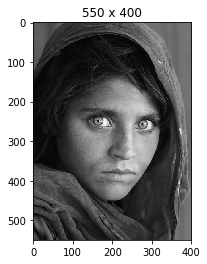

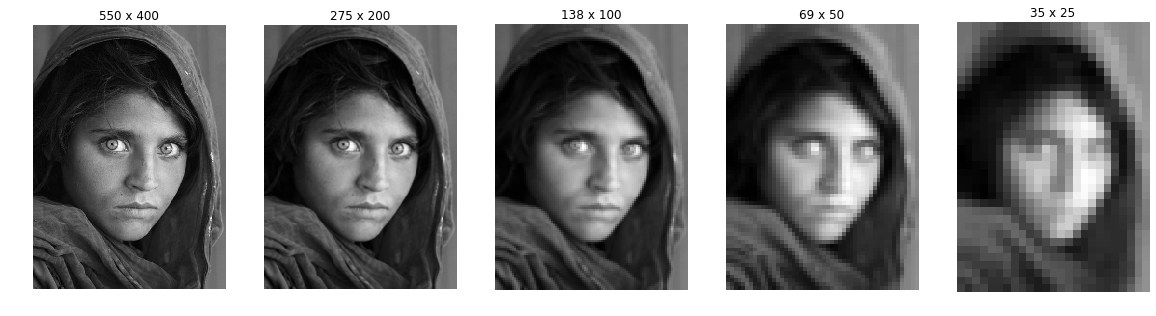

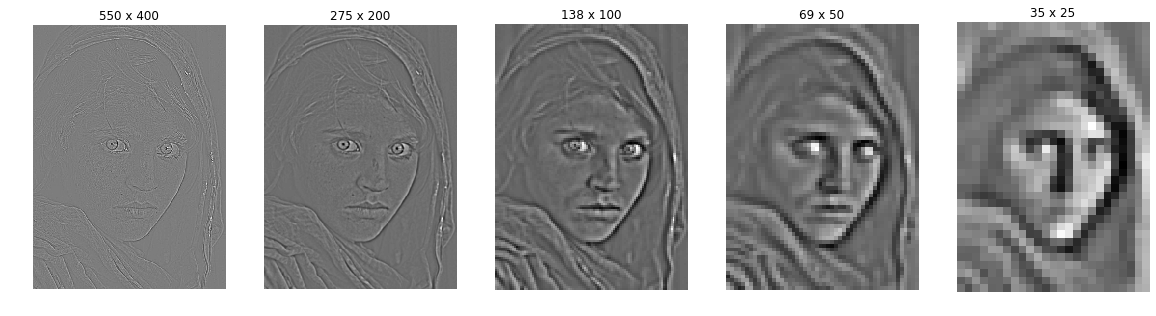

In [107]:
img = cv2.imread("datas/Afghan_girl_before.jpg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float64)
plt.imshow(img_gray, cmap='gray'), plt.title("%d x %d"%(img_gray.shape)), plt.show()

num_layers = 5
gaussian_pyramid, laplacian_pyramid = image_pyramid(img_gray)

# Plot Gaussian pyramid
plt.figure(figsize = (20,10))
for i, gaussian in enumerate(gaussian_pyramid[:5]):
    m, n = gaussian.shape
    plt.subplot(1, num_layers, i+1), plt.axis('off'), 
    plt.title("%d x %d"%(m,n)), plt.imshow(gaussian.astype(np.uint8), cmap='gray')
plt.show()

# Plot Laplacian pyramid
plt.figure(figsize = (20,10))
for i, laplacian in enumerate(laplacian_pyramid[:5]):
    laplacian -= laplacian.min()
    m, n = laplacian.shape
    plt.subplot(1, num_layers, i+1), plt.axis('off'), 
    plt.title("%d x %d"%(m,n)), plt.imshow(laplacian.astype(np.uint8), cmap='gray')
plt.show()

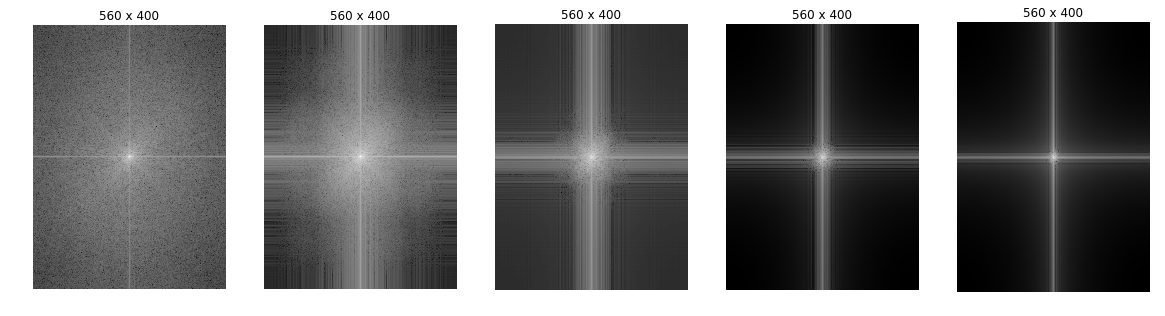

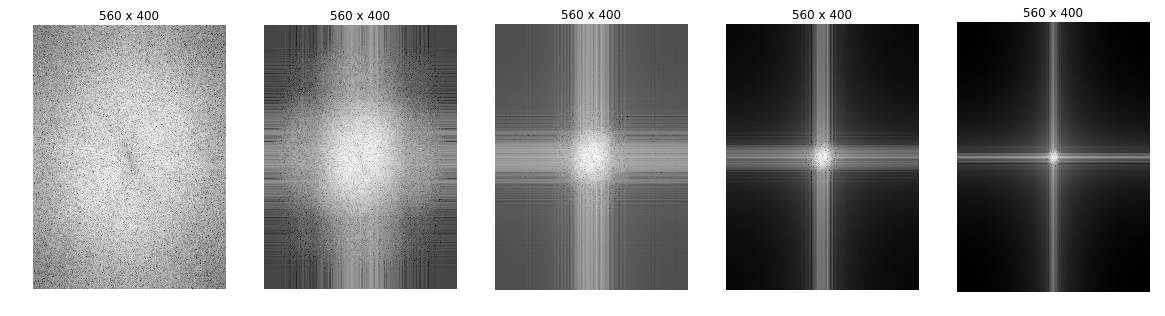

In [119]:

gaussian_pyramid, laplacian_pyramid = image_pyramid(img_gray)

# Plot Gaussian frequency magnitude spectrum
magnitude_spectrums = [] 
lowest = 1e+10
highest = -1e+10
for i, gaussian in enumerate(gaussian_pyramid[:5]):
    for k in range(i):
        gaussian = pyramid_upsample(gaussian.reshape(gaussian.shape[0], gaussian.shape[1], 1))
    if len(gaussian.shape) > 2:
        gaussian = gaussian[:, : ,0]
    m, n = gaussian.shape
    f = np.fft.fft2(gaussian)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.log10(np.abs(fshift))
    magnitude_spectrums.append(magnitude_spectrum)
    lowest = min(lowest, np.nanmin(magnitude_spectrum[np.isfinite(magnitude_spectrum)]))
    highest = max(highest, np.nanmax(magnitude_spectrum[np.isfinite(magnitude_spectrum)]))
    
plt.figure(figsize = (20,10))
for i, magnitude_spectrum in enumerate(magnitude_spectrums[:5]):
    original_range = highest - lowest
    norm_fourier = (magnitude_spectrum - lowest) / original_range * 255
    plt.subplot(1, num_layers, i+1), plt.axis('off'), 
    plt.title("%d x %d"%(m,n)), plt.imshow(norm_fourier, cmap='gray')
plt.show()

# Plot Laplacian frequency magnitude spectrum
magnitude_spectrums = [] 
lowest = 1e+10
highest = -1e+10
for i, laplacian in enumerate(laplacian_pyramid[:5]):
    for k in range(i):
        laplacian = pyramid_upsample(laplacian.reshape(laplacian.shape[0], laplacian.shape[1], 1))
    if len(laplacian.shape) > 2:
        laplacian = laplacian[:, : ,0]
    m, n = laplacian.shape
    f = np.fft.fft2(laplacian)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.log10(np.abs(fshift))
    magnitude_spectrums.append(magnitude_spectrum)
    lowest = min(lowest, np.nanmin(magnitude_spectrum[np.isfinite(magnitude_spectrum)]))
    highest = max(highest, np.nanmax(magnitude_spectrum[np.isfinite(magnitude_spectrum)]))
plt.figure(figsize = (20,10))
for i, magnitude_spectrum in enumerate(magnitude_spectrums[:5]):
    original_range = highest - lowest
    norm_fourier = (magnitude_spectrum - lowest) / original_range * 255
    plt.subplot(1, num_layers, i+1), plt.axis('off'), 
    plt.title("%d x %d"%(m,n)), plt.imshow(norm_fourier, cmap='gray')
plt.show()

In [ ]:
import glob
img_names = glob.glob('datas/*')
import os

In [ ]:
for img_name in img_names:
    img = cv2.imread(img_name)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

    gaussian_filter = get_gaussian_filter(kernel_size=(7,7), sigma=1.5)
    num_layers = 5
    gaussian_pyramid, laplacian_pyramid = image_pyramid(img_gray, gaussian_filter, num_layers, ratio=2)

    # Plot Gaussian pyramid
    plt.figure(figsize = (10,10))
    plt.tight_layout()
    for i, gaussian in enumerate(gaussian_pyramid[:-1]):
        m, n = gaussian.shape
        plt.subplot(4, num_layers, i+1), plt.axis('off'), 
        plt.imshow(gaussian, cmap='gray')

    # Plot Laplacian pyramid
    for i, laplacian in enumerate(laplacian_pyramid):
        m, n = laplacian.shape
        plt.subplot(4, num_layers, i+1+5), plt.axis('off'), 
        plt.imshow(laplacian, cmap='gray')


    gaussian_pyramid, laplacian_pyramid = image_pyramid(img_gray, gaussian_filter, num_layers, ratio=1)
    # Plot Gaussian frequency magnitude spectrum
    magnitude_spectrums = [] 
    lowest = 1e+10
    highest = -1e+10
    for i, gaussian in enumerate(gaussian_pyramid[:-1]):
        m, n = gaussian.shape
        f = np.fft.fft2(gaussian)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = np.log10(np.abs(fshift))
        magnitude_spectrums.append(magnitude_spectrum)
        lowest = min(lowest, np.nanmin(magnitude_spectrum[np.isfinite(magnitude_spectrum)]))
        highest = max(highest, np.nanmax(magnitude_spectrum[np.isfinite(magnitude_spectrum)]))
    for i, magnitude_spectrum in enumerate(magnitude_spectrums):
        original_range = highest - lowest
        norm_fourier = (magnitude_spectrum - lowest) / original_range * 255
        plt.subplot(4, num_layers, i+1+10), plt.axis('off'), 
        plt.imshow(norm_fourier, cmap='gray')


    # Plot Laplacian frequency magnitude spectrum
    magnitude_spectrums = [] 
    lowest = 1e+10
    highest = -1e+10
    for i, laplacian in enumerate(laplacian_pyramid):
        m, n = laplacian.shape
        f = np.fft.fft2(laplacian)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = np.log10(np.abs(fshift))
        magnitude_spectrums.append(magnitude_spectrum)
        lowest = min(lowest, np.nanmin(magnitude_spectrum[np.isfinite(magnitude_spectrum)]))
        highest = max(highest, np.nanmax(magnitude_spectrum[np.isfinite(magnitude_spectrum)]))
    for i, magnitude_spectrum in enumerate(magnitude_spectrums):
        original_range = highest - lowest
        norm_fourier = (magnitude_spectrum - lowest) / original_range * 255
        plt.subplot(4, num_layers, i+1+15), plt.axis('off'), 
        plt.imshow(norm_fourier, cmap='gray')
    
    base=os.path.basename(img_name)
    file_name = os.path.splitext(base)[0] + '.jpg'
    plt.savefig('results/' + file_name)